In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import imageio
import numpy as np
from scipy.stats import multivariate_normal
import torch.nn as nn
import torch.nn.functional as F
import argparse
import json
from model import GMVAE

In [36]:
MODEL_NUM = 2

# Load the parameters from the JSON file into a dictionary
with open(f'log_ref.json', 'r') as f:
    dict_ = json.load(f)
params = dict_[str(MODEL_NUM)]
# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**params)
args.device = 'cpu'

<Axes: xlabel='Epoch'>

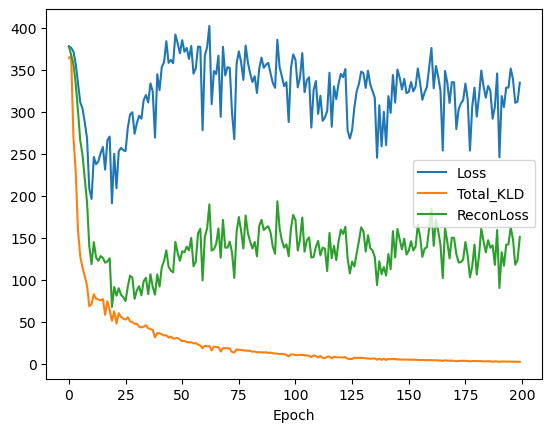

In [37]:
df = pd.read_csv(f'logs/{MODEL_NUM}.csv')

df['Total_KLD'] = df['KLD_W'] + df['KLD_Z']

df_train = df[df['Mode'] == 'Train']
df_train.plot(x='Epoch', y=['Loss', 'Total_KLD', 'ReconLoss'])


In [38]:
def plot_samples(samples, epoch, save_dir):
    # Grid for the contour plot
    x = np.linspace(-4, 4, 500)
    y = np.linspace(-4, 4, 500)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    # Bimodal Gaussian distribution
    mean1 = np.array([-1, -1])
    mean2 = np.array([-1, 1])
    mean3 = np.array([1, -1])
    mean4 = np.array([1, 1])

    cov = np.array([[.1, 0], [0, .1]])
    Z = 0.25*(multivariate_normal(mean1, cov).pdf(pos) + multivariate_normal(mean2, cov).pdf(pos) + multivariate_normal(mean3, cov).pdf(pos) + multivariate_normal(mean4, cov).pdf(pos))

    plt.figure(figsize=(10, 10))
    plt.contour(X, Y, Z, colors='r', alpha=0.5)  # True distribution in red
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)  # Model's distribution
                       
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title(f'Epoch {epoch}')
    plt.savefig(f'{save_dir}/scatter_{epoch}.png')
    plt.close()

model_dir = f'./saved_models/{MODEL_NUM}/'
plot_dir = './figures/recon_viz'
os.makedirs(plot_dir, exist_ok=True)

images = []
epochs = 200
model = GMVAE(args)
for epoch in range(0, args.epochs, args.save_interval):
    model_file = os.path.join(model_dir, f'model_{epoch}.pth')
    model.load_state_dict(torch.load(model_file))
    model.eval()
    
    samples = model.sample(10000).detach().numpy()
    
    plot_samples(samples, epoch, plot_dir)
    
    images.append(imageio.imread(f'{plot_dir}/scatter_{epoch}.png'))

# Save gif
imageio.mimsave(f'/figures/vae_mog_training.gif', images, duration=10)


/var/folders/b_/x8lg97sd7512c9qf07myy77m0000gn/T/ipykernel_8591/3252558127.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'{plot_dir}/scatter_{epoch}.png'))


KeyboardInterrupt: 